In [8]:
import io
import random
import json
import csv
import os.path as osp
import ase
from ase.io import read as ase_read
import ase.io
import numpy as np
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch_geometric.data import Data, Dataset, InMemoryDataset
from mp_api.client import MPRester
from torch_geometric.utils import dense_to_sparse, add_self_loops
from torch.utils.data import random_split, Subset
from typing import Sequence
from itertools import permutations

from model import load_model
import copy

from args import *
from utils import *

In [9]:
# PREDICT_DATA_PATH = "results/PNA/1720343668248499/1G_opt_hypo_predict.pt"
# PREDICT_DATA_PATH = "results/CEAL/1721394414722252/1G_opt_hypo_predict.pt"
PREDICT_DATA_PATH = "results/CEAL/1717473742365643/1G_opt_hypo_predict.pt"

# PREDICT_DATA_PATH = "results/CEAL/1721381969665949/1G_opt_hypo_predict.pt"
# PREDICT_DATA_PATH = "results/OriginCEAL/1721108321656544/1G_opt_hypo_predict.pt"

from opt_hypo_dataset import *

device = get_device("cpu")

pred_data_list, pred_data_id_list = torch.load(PREDICT_DATA_PATH)
pred_data_list = pred_data_list.to(device)
dft_data_list_ = torch.zeros(0).to(device)

dataset = Optimized_hypo_dataset(args)

for pred_data_id, data in zip(pred_data_id_list, dataset):
    if int(pred_data_id.item()) != int(data.id.item()):
        print("ID unmatched: ", pred_data_id.item())
    y = data.y.to(device)
    dft_data_list_ = torch.cat((dft_data_list_, y), 0)

min, max = get_data_scale(args, data_path=DATASET_OPT_HYPO_RAW_DIR)
print(min, max)
dft_data_list = reverse_min_max_scalar_1d(dft_data_list_, min, max)

-2.0707778930664062 4.350278854370117


Ef<0: 2327
Ef>0: 2200
ratio of Ef<0  0.5140269494146233


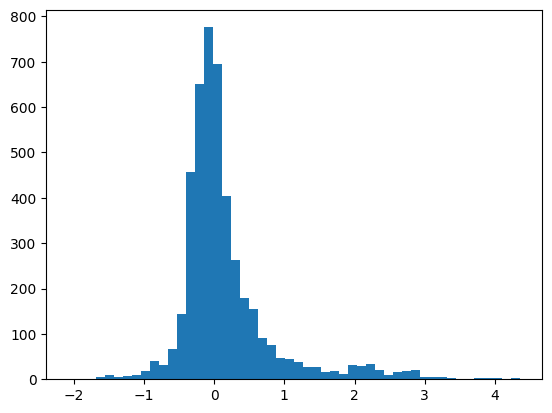

In [10]:
plt.clf()
plt.hist(dft_data_list.to("cpu"), bins=50)
print("Ef<0:", len(dft_data_list[dft_data_list < 0.0]))
print("Ef>0:", len(dft_data_list[dft_data_list > 0.0]))
print("ratio of Ef<0 ", len(dft_data_list[dft_data_list < 0.0]) / len(dft_data_list))
plt.show()

negative formation energy ratio: 0.5140269494146233
MAE=  2.485811132760048


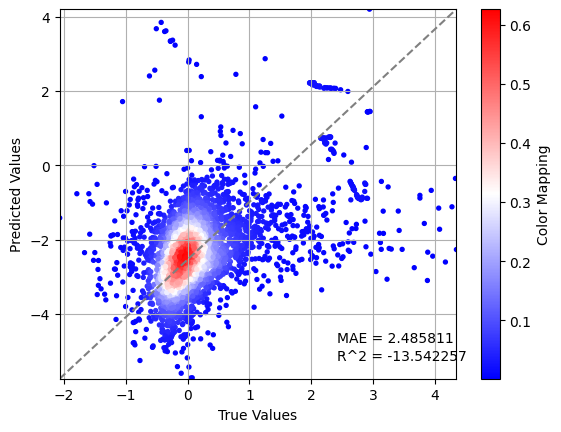

In [15]:
total = len(dft_data_list)

# print("MAE: ")
print("negative formation energy ratio:", len(dft_data_list[dft_data_list < 0.0]) / total)
save_regression_result(pred_data_list, dft_data_list, ".")
plot_regression_result("", ".", scope=[-5, 2, -5, 2])

In [ ]:
# DATASET_1G = "1G_DFT_dataset/"
# FORMATION_ENERGY_NAME = "FORMATION_ENERGY_"
# MATERIAL_NAME = "POSCAR_"
# TOTAL_DATASET_NUM = 4542



# sample_data = torch.load(SAMPLE_DATA_PATH)

# res_pred_list = torch.zeros(0)
# res_DFT_list = torch.zeros(0)


# MAE = 0.0
# total = 0
# for i in range(1, TOTAL_DATASET_NUM + 1):
#     res_DFT_data_path = osp.join(DATASET_1G, FORMATION_ENERGY_NAME + str(i))
#     material_data_path = osp.join(DATASET_1G, MATERIAL_NAME + str(i))

#     exist = False
#     if osp.exists(res_DFT_data_path):
#         with open(res_DFT_data_path, "r") as file:
#             res_DFT = file.readline()
#         try:
#             res_DFT = torch.Tensor([float(res_DFT)])
#             exist = True
#         except:
#             print(res_DFT_data_path)
#         file.close()
#     else:
#         print("Not exist:", res_DFT_data_path)

#     if osp.exists(material_data_path) and exist:
#         res_pred = torch.Tensor([sample_data["pred_list"][i - 1]])

#         # out_range = torch.abs(res_pred - res_DFT) > 1.0
#         # if out_range.item():
#         #     continue

#         total += 1
#         res_pred_list = torch.cat((res_pred_list, res_pred), 0)
#         res_DFT_list = torch.cat((res_DFT_list, res_DFT), 0)

#         abs_error = torch.abs(torch.subtract(res_DFT, res_pred)).item()
#         # print(res_DFT, res_pred, abs_error)
#         MAE = MAE + abs_error
#         # print(i, MAE, abs_error, res_DFT, res_pred)  # 1847

#     # if osp.exists(material_data_path) is False:
#     #     print(material_data_path)

#     # if osp.exists(res_DFT_data_path) is False:
#     #     print(res_DFT_data_path)


# print(MAE, total, MAE / total)
# print(len(res_pred_list), len(res_DFT_list))

# print("negative formation energy ratio:", len(res_DFT_list[res_DFT_list < 0.0]) / total)
# save_regression_result(res_pred_list, res_DFT_list, ".")
# plot_regression_result("", ".")

# print(res_pred_list, res_DFT_list)


# # # 将 tensor 转换为 numpy 数组
# # array1 = res_pred_list.numpy().flatten()
# # array2 = res_DFT_list.numpy()

# # # 创建一个 DataFrame
# # data = pd.DataFrame({"Tensor1": array1, "Tensor2": array2})

# # # 使用 Seaborn 的 lmplot 绘制线性回归图
# # sns.lmplot(x="Tensor2", y="Tensor1", data=data, ci=None)

# # # 显示图表
# # plt.show()

In [ ]:
# # Get all predict data
# sample_data
# # print(len(sample_data["pred_list"]))